In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import erftools.constants as const
from erftools.utils.microphysics import erf_qsatw as getqvs

# Base state initialization based on `mbm.F`
from George Bryan (https://www2.mmm.ucar.edu/people/bryan/Code/mbm.F)

In [3]:
# user settings
nk = 100
dz = 100.0
th_sfc = 289.8486 # potential temperature at surface [K]
p_sfc = 100000.0  # pressure at surface [Pa]
qt_mb = 0.020     # total water mixing ratio [kg/kg]
the_ref = 320.0   # reference wet equivalent potential temperature [K]

In [4]:
# map constants in Bryan's code to constants in ERF
g = const.CONST_GRAV
to = 273.15
rd = const.R_d
rv = const.R_v
cp = const.Cp_d
cpv = const.Cp_v
p00 = const.p_0
rp00 = 1.0/p00
eps = rd/rv
reps = rv/rd
xlv = const.L_v

# NOT in ERF:
cpl = 4190.0 # specific heat of liquid water at constant pressure
lv1 = xlv + (cpl-cpv)*to
lv2 = cpl - cpv

In [5]:
MAXITER = 100
TOL = 1e-4 # the_e rmse 0.14631473283308954
#TOL = 1e-5 # the_e rmse 0.14744620851274448

## surface values
* use definition of exner pressure to set $\pi$ and and air temperature $T$
* water vapor mixing ratio $q_v$ is at saturation point
* liquid water mixing ratio $q_l$ == $q_c$, the cloud water mixing ratio, in this work
* $q_t = q_v + q_l$
* virtual potential temperature definition: $\theta_v = \theta \frac{\epsilon + q_v}{\epsilon (1 + q_v + q_l)}$

In [6]:
def calc_thv(th, qv, ql):
    return th * (1 + reps*qv) / (1 + qv+ql)

In [7]:
pi_sfc  = (p_sfc/p00)**(rd/cp)
t_sfc   = th_sfc * pi_sfc
qv_sfc  = getqvs(t_sfc, p_sfc)
ql_sfc  = qt_mb - qv_sfc
thv_sfc = calc_thv(th_sfc, qv_sfc, ql_sfc)

In [8]:
t1   = t_sfc
th1  = th_sfc
qv1  = qv_sfc
ql1  = ql_sfc
p1   = p_sfc
pi1  = pi_sfc
thv1 = calc_thv(th1, qv1, ql1)

## integrate up column
* apply hydrostatic equation $\frac{d\pi}{dz} = - \frac{g}{c_p\theta_{\rho 0}}$
* use virtual potential temperature instead of density potential temperature

In [9]:
t0 = np.zeros(nk)
th0 = np.zeros(nk)
thv0 = np.zeros(nk)
prs0 = np.zeros(nk)
pi0 = np.zeros(nk)
qv0 = np.zeros(nk)
ql0 = np.zeros(nk)

In [10]:
for k in range(nk):
    
    # staggered grid: first grid level is 1/2 dz above ground
    delz = 0.5*dz if k==0 else dz

    thlast = th1
    th2 = th1
    thv2 = thv1
    
    n = 0
    converged = False
    while not converged:
        
        pi2 = pi1 - delz * g / (cp*0.5*(thv1+thv2))
        p2 = p00 * pi2**(cp/rd)
        t2 = thlast * pi2
        qv2 = getqvs(t2, p2)
        ql2 = qt_mb - qv2
        thv2 = calc_thv(th2, qv2, ql2)
        
        tbar = 0.5*(t1+t2)
        qvbar = 0.5*(qv1+qv2)
        qlbar = 0.5*(ql1+ql2)

        lhv = lv1 - lv2*tbar
        rm = rd + rv*qvbar
        cpm = cp + cpv*qvbar + cpl*qlbar

        # model-specific thermodynamic equation here
        th2 = th1 * np.exp( -lhv * (qv2-qv1) / (cpm*tbar)
                           + (rm/cpm - rd/cp) * np.log(p2/p1) )
        
        diff = th2 - thlast
        if np.abs(diff) > TOL:
            thlast = thlast + 0.30*(th2-thlast)
        else:
            converged = True

        n += 1
        assert n < MAXITER, 'Error: Solution is not converging'

    print('Level',k,'converged after',n,'steps')

    t2 = th2 * pi2
    qv2 = getqvs(t2, p2)
    ql2 = qt_mb - qv2
    assert ql2 > 0, 'Error: ql < 0'
    
    thv2 = calc_thv(th2, qv2, ql2)
    
    t0[k] = t2
    th0[k] = th2
    thv0[k] = thv2
    prs0[k] = p2
    pi0[k] = pi2
    qv0[k] = qv2
    ql0[k] = ql2

    t1 = t2
    th1 = th2
    thv1 = thv2
    p1 = p2
    pi1 = pi2
    qv1 = qv2
    ql1 = ql2

Level 0 converged after 7 steps
Level 1 converged after 7 steps
Level 2 converged after 7 steps
Level 3 converged after 7 steps
Level 4 converged after 8 steps
Level 5 converged after 8 steps
Level 6 converged after 8 steps
Level 7 converged after 8 steps
Level 8 converged after 8 steps
Level 9 converged after 8 steps
Level 10 converged after 8 steps
Level 11 converged after 8 steps
Level 12 converged after 9 steps
Level 13 converged after 9 steps
Level 14 converged after 9 steps
Level 15 converged after 9 steps
Level 16 converged after 9 steps
Level 17 converged after 9 steps
Level 18 converged after 9 steps
Level 19 converged after 10 steps
Level 20 converged after 10 steps
Level 21 converged after 10 steps
Level 22 converged after 10 steps
Level 23 converged after 10 steps
Level 24 converged after 10 steps
Level 25 converged after 10 steps
Level 26 converged after 11 steps
Level 27 converged after 11 steps
Level 28 converged after 11 steps
Level 29 converged after 11 steps
Level 30 

## plot profiles

In [11]:
zlevels = dz/2 + np.arange(nk)*dz

In [12]:
Tv0 = thv0 * pi0 # virtual temperature
dens0 = prs0 / (rd*Tv0)

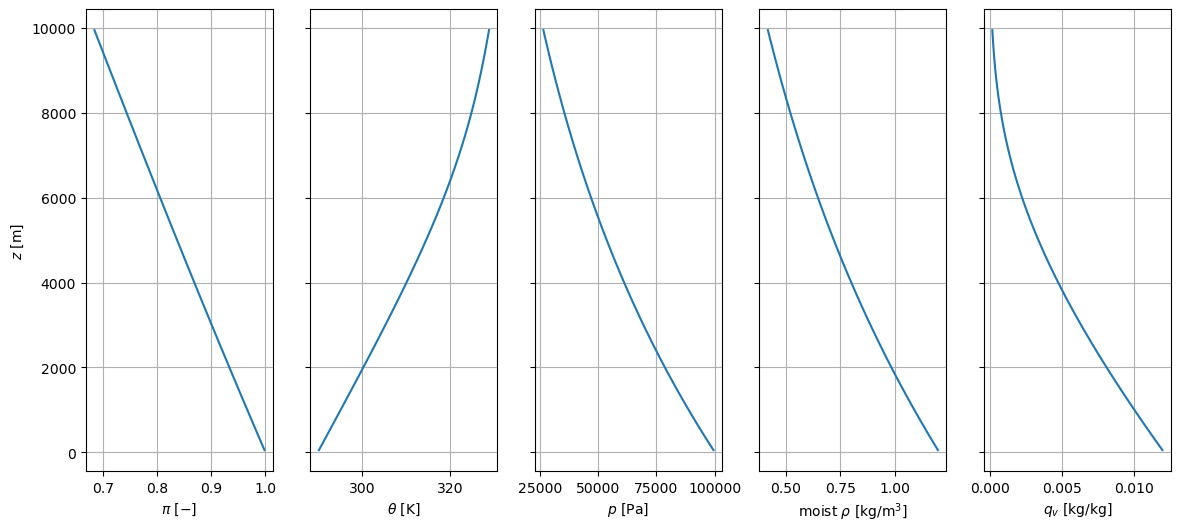

In [13]:
fig,axs = plt.subplots(ncols=5,sharey=True,figsize=(14,6))

axs[0].plot(pi0, zlevels)
axs[0].set_xlabel(r'$\pi$ [$-$]')

axs[1].plot(th0, zlevels)
axs[1].set_xlabel(r'$\theta$ [K]')

axs[2].plot(prs0, zlevels)
axs[2].set_xlabel(r'$p$ [Pa]')

axs[3].plot(dens0, zlevels)
axs[3].set_xlabel(r'moist $\rho$ [kg/m$^3$]')

axs[4].plot(qv0, zlevels)
axs[4].set_xlabel(r'$q_v$ [kg/kg]')

axs[0].set_ylabel(r'$z$ [m]')
for ax in axs:
    ax.grid()

fig.savefig('BryanFritsch2002_moist_sounding.png',bbox_inches='tight')

## check saturation conditions

In [14]:
qvs = np.array([getqvs(t0_k, p0_k) for t0_k,p0_k in zip(t0, prs0)])

In [15]:
assert np.all(qv0 == qvs)

## check $\theta_e$

NOTE: this is only approximately satisfied

In [16]:
# calc dry pressure -- do we need to account for the cloud contribution to total pressure?
e0 = qv0 / (qt_mb + eps) * prs0
pd0 = prs0 - e0

In [17]:
denom = cp + cpl*qt_mb
th_e = t0 * (pd0/p00)**(-rd/denom) * np.exp(xlv*qv0 / (denom*t0))

print(np.std(th_e - the_ref))

0.14631473283308954


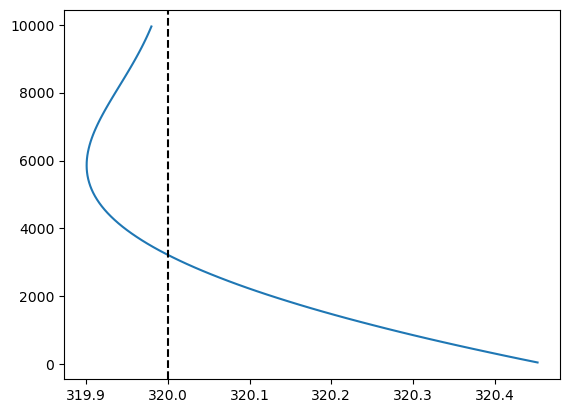

In [18]:
fig,ax = plt.subplots()
ax.plot(th_e, zlevels)
ax.axvline(the_ref, color='k', ls='--')

## write out sounding

In [19]:
with open('BryanFritsch2002_moist_sounding','w') as f:
    # note: water vapor mixing ratio units are g/kg
    f.write(f'{p_sfc/100:g} {th_sfc:g} {qv_sfc*1000:g}\n')
    for k,zlev in enumerate(zlevels):
        f.write(f'{zlev:4g} {th0[k]:g} {qv0[k]*1000:g} 0 0\n')